# VCGC: Vertex Coloring with Grover's Circuit - G2
Rudimentary Curcuit To Run Grover's Search Algorithm for a vertex coloring instance on the AER simulator and IBM's Quantum Computer. 

### 1. Prepare the circuit and add the uniform state preparation operator. 

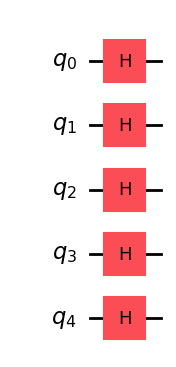

In [20]:
from qiskit import *

num_qubits = 5
# Subcircuit for uniform state preparation operator
state_prep_oracle= QuantumCircuit(num_qubits,name="state_prep")

# Add a H gate on all qubits except the last one
# This will give the superposition of all the qubits except the last one
for qubit in range(num_qubits):
    state_prep_oracle.h(qubit)

# qc.decompose(gates_to_decompose="state_prep").draw('mpl')
state_prep_oracle.draw('mpl')

### 2. Manually creating the oracle circuit for evaluating the scaled down vertex coloring problem shown below

![Simple Vertex Coloring problem](graphs/g4.png)

In [21]:
num_qubits_oracle = 11

#### Regular Grover Oracle

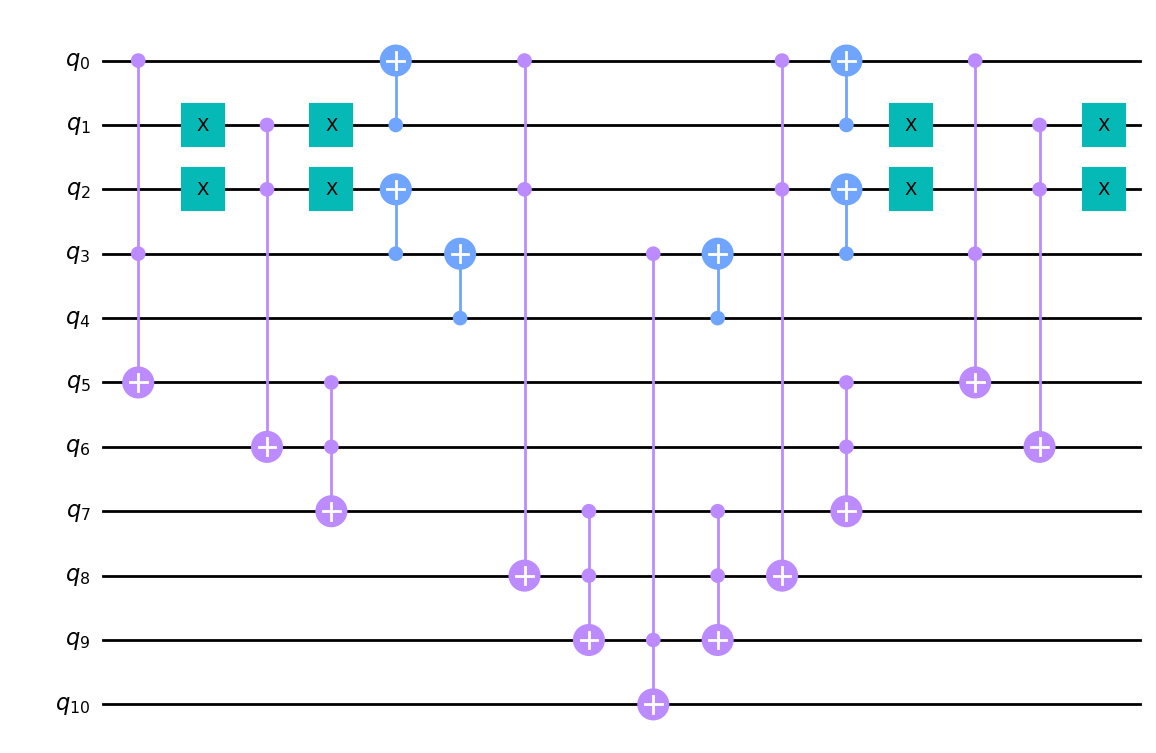

In [22]:
grover_oracle_reg = QuantumCircuit(num_qubits_oracle, name="grover_oracle_reg")
grover_oracle_reg.ccx(0,3,5)
grover_oracle_reg.x(1)
grover_oracle_reg.x(2)
grover_oracle_reg.ccx(1,2,6)
grover_oracle_reg.x(1)
grover_oracle_reg.x(2)
grover_oracle_reg.cx(1,0)
grover_oracle_reg.cx(3,2)
grover_oracle_reg.cx(4,3)
grover_oracle_reg.ccx(5,6,7)
grover_oracle_reg.ccx(0,2,8)
grover_oracle_reg.ccx(7,8,9)
grover_oracle_reg.ccx(3,9,10)
grover_oracle_reg.ccx(7,8,9)
grover_oracle_reg.ccx(0,2,8)
grover_oracle_reg.ccx(5,6,7)
grover_oracle_reg.cx(4,3)
grover_oracle_reg.cx(3,2)
grover_oracle_reg.cx(1,0)
grover_oracle_reg.x(2)
grover_oracle_reg.x(1)
grover_oracle_reg.ccx(1,2,6)
grover_oracle_reg.x(2)
grover_oracle_reg.x(1)
grover_oracle_reg.ccx(0,3,5)

grover_oracle_reg.draw('mpl',style='clifford')

#### Inverted Grover Oracle 

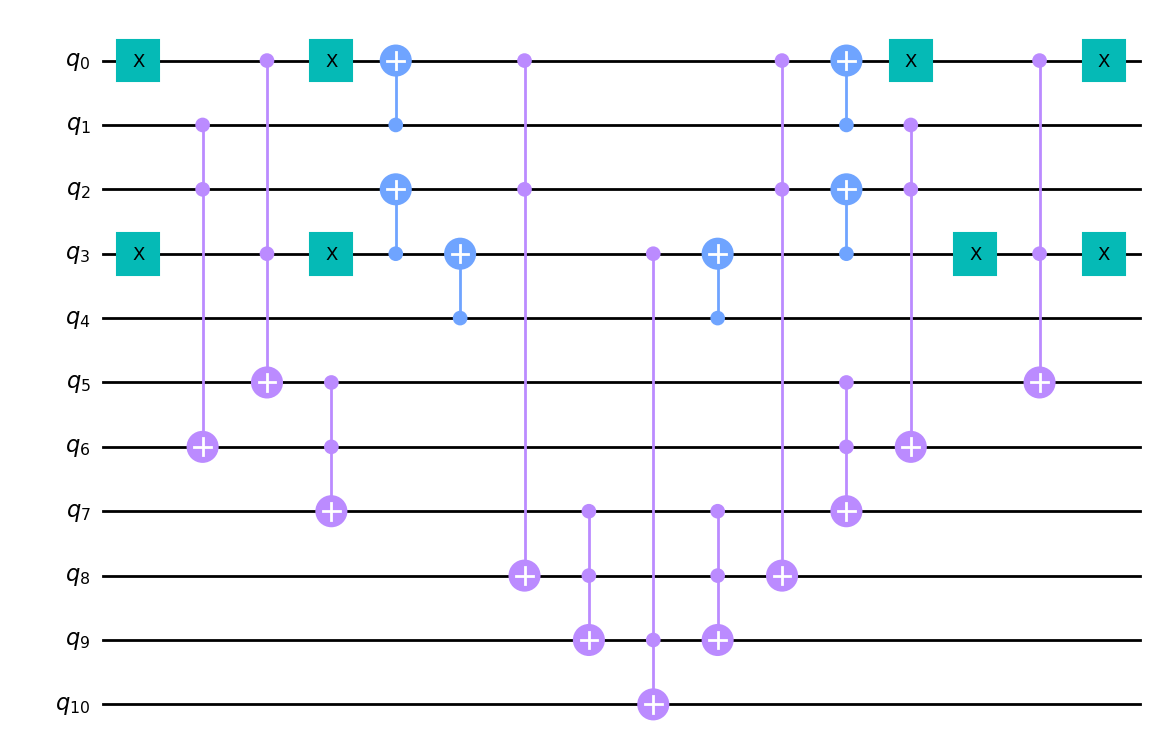

In [23]:
grover_oracle_inverted = QuantumCircuit(num_qubits_oracle, name="grover_oracle_inverted")
grover_oracle_inverted.x(0)
grover_oracle_inverted.x(3)
grover_oracle_inverted.ccx(0,3,5)
grover_oracle_inverted.x(0)
grover_oracle_inverted.x(3)
grover_oracle_inverted.ccx(1,2,6)
grover_oracle_inverted.cx(1,0)
grover_oracle_inverted.cx(3,2)
grover_oracle_inverted.cx(4,3)
grover_oracle_inverted.ccx(5,6,7)
grover_oracle_inverted.ccx(0,2,8)
grover_oracle_inverted.ccx(7,8,9)
grover_oracle_inverted.ccx(3,9,10)
grover_oracle_inverted.ccx(7,8,9)
grover_oracle_inverted.ccx(0,2,8)
grover_oracle_inverted.ccx(5,6,7)
grover_oracle_inverted.cx(4,3)
grover_oracle_inverted.cx(3,2)
grover_oracle_inverted.cx(1,0)
grover_oracle_inverted.ccx(1,2,6)
grover_oracle_inverted.x(0)
grover_oracle_inverted.x(3)
grover_oracle_inverted.ccx(0,3,5)
grover_oracle_inverted.x(0)
grover_oracle_inverted.x(3)
grover_oracle_inverted.draw('mpl', style='clifford')


### 3. Defining the diffusion operator

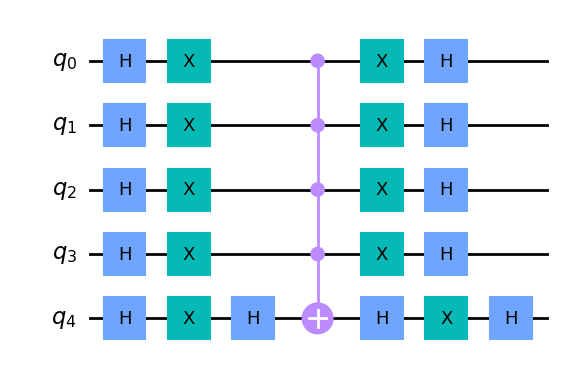

In [24]:
# Create a quantum subcircuit for grover diffusion operator
def create_grover_diffusion_operator(num_qubits):
    # Create a quantum subcircuit for grover diffusion operator
    grover_diff = QuantumCircuit(num_qubits, name="grover_diffusion")
    grover_diff.h(range(num_qubits))
    grover_diff.x(range(num_qubits))
    grover_diff.h(num_qubits - 1)
    grover_diff.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    grover_diff.h(num_qubits - 1)
    grover_diff.x(range(num_qubits))
    grover_diff.h(range(num_qubits))
    return grover_diff

grover_diffusion = create_grover_diffusion_operator(num_qubits)

grover_diffusion.draw('mpl',style='clifford')

### 4. Connect the whole circuit together

In [25]:
# Combining the subcircuits to form the complete Grover's algorithm
# Create a Quantum Circuit acting on a quantum register of 5 qubits

def prepare_circuit(qc: QuantumCircuit, num_qubits, num_qubits_oracle, state_prep: QuantumCircuit, grover_oracle: QuantumCircuit, grover_diff: QuantumCircuit):
    qc.barrier()
    qc.x(num_qubits_oracle - 1)
    qc.h(num_qubits_oracle - 1)
    # Apply the state preparation operator
    qc.append(state_prep, list(range(num_qubits)))
    qc.barrier()
    # Apply the Grover oracle
    qc.append(grover_oracle, list(range(num_qubits_oracle)))
    qc.barrier()
    # Apply the Grover diffusion operator
    qc.append(grover_diff, list(range(num_qubits)))
    qc.barrier()

qc_reg = QuantumCircuit(num_qubits_oracle,num_qubits_oracle)
prepare_circuit(qc_reg, num_qubits, num_qubits_oracle, state_prep_oracle, grover_oracle_reg, grover_diffusion)
qc_inverted = QuantumCircuit(num_qubits_oracle,num_qubits_oracle)
prepare_circuit(qc_inverted, num_qubits, num_qubits_oracle, state_prep_oracle, grover_oracle_inverted, grover_diffusion)

#### Regular Circuit

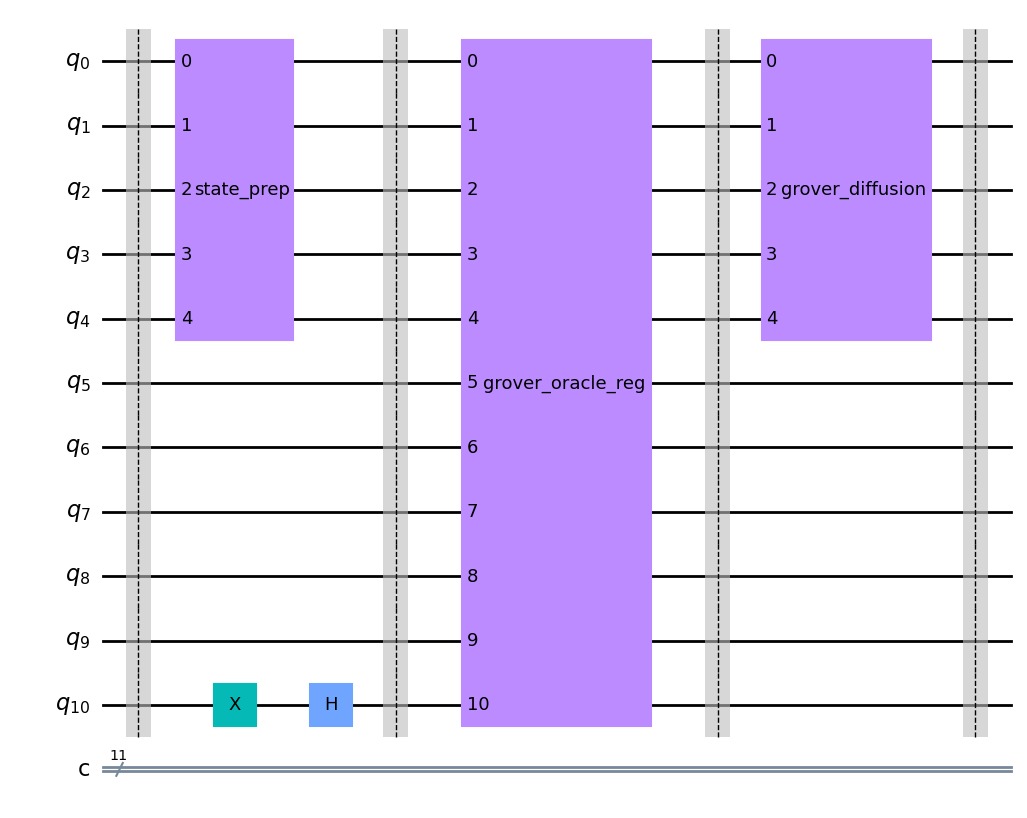

In [26]:

qc_reg.draw('mpl', style='clifford', filename='grover_circuit_reg.png')

#### Inverted Circuit

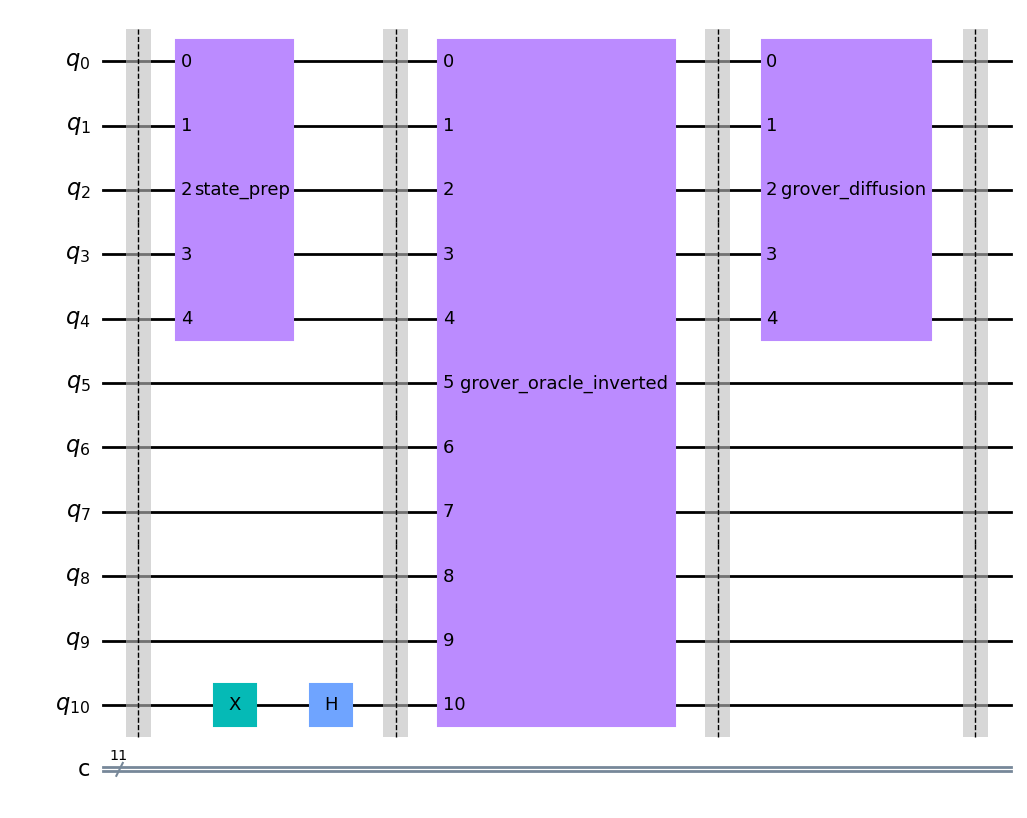

In [27]:
qc_inverted.draw('mpl', style='clifford', filename='grover_circuit_inverted.png')

### 5. Add measurements and decompose the circuits for the AER simulator

#### Regular circuit

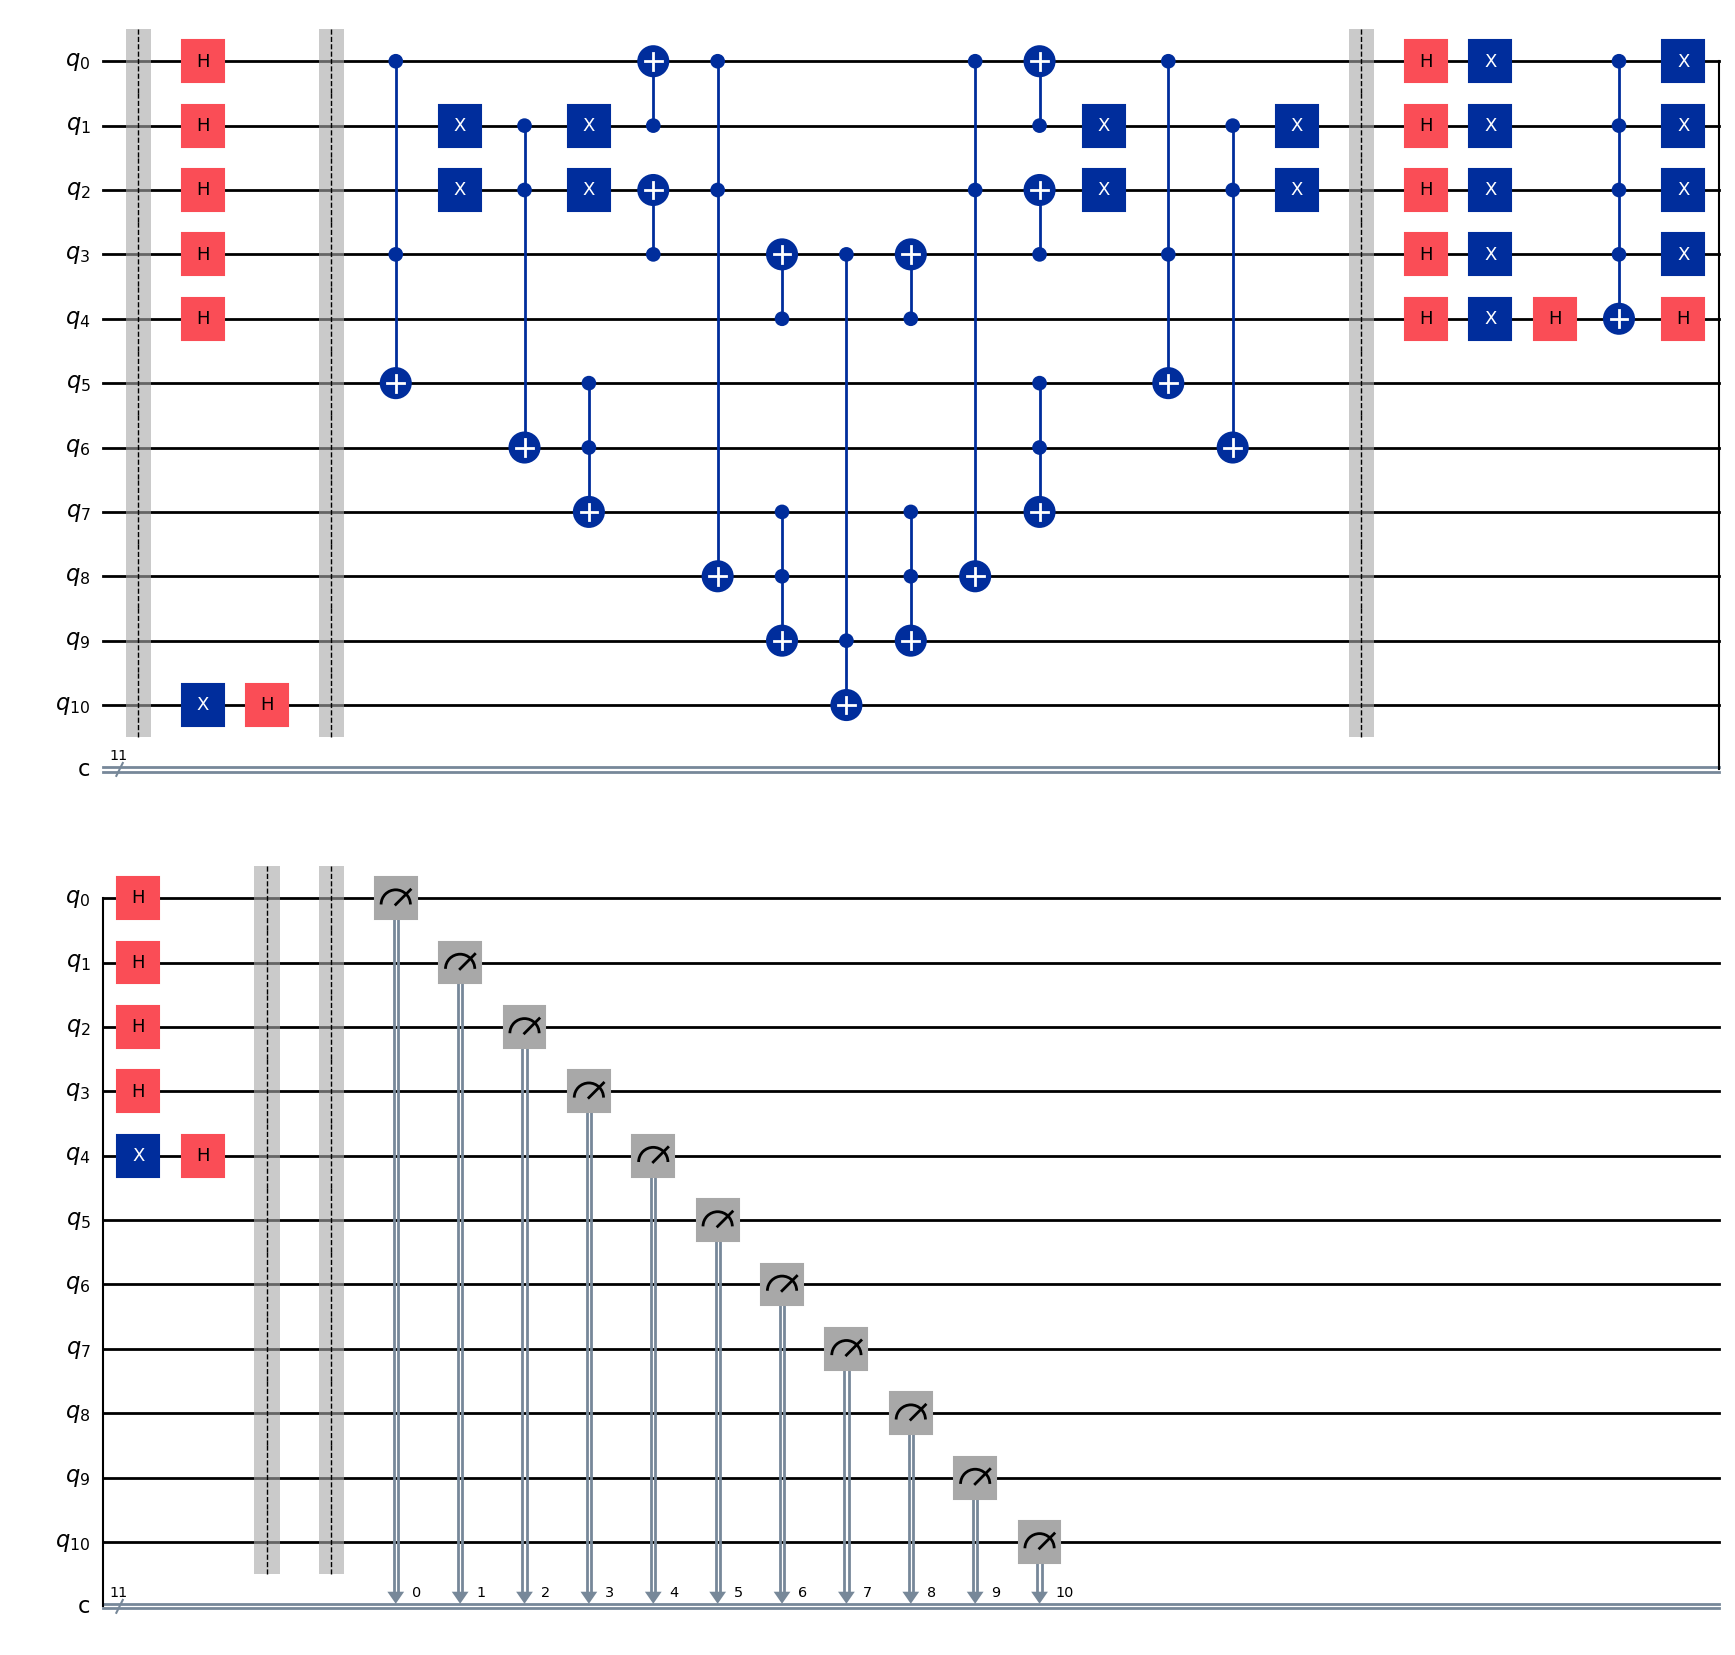

In [28]:
qc_reg.measure_all(add_bits=False)
# qc_reg.measure(list(range(num_qubits)), list(range(num_qubits))) # Measure the first 3 qubits
qc_decomposed_reg : QuantumCircuit = qc_reg.decompose(gates_to_decompose=["state_prep", "grover_oracle_reg", "grover_diffusion"])
qc_decomposed_reg.draw('mpl')


#### Inverted Circuit

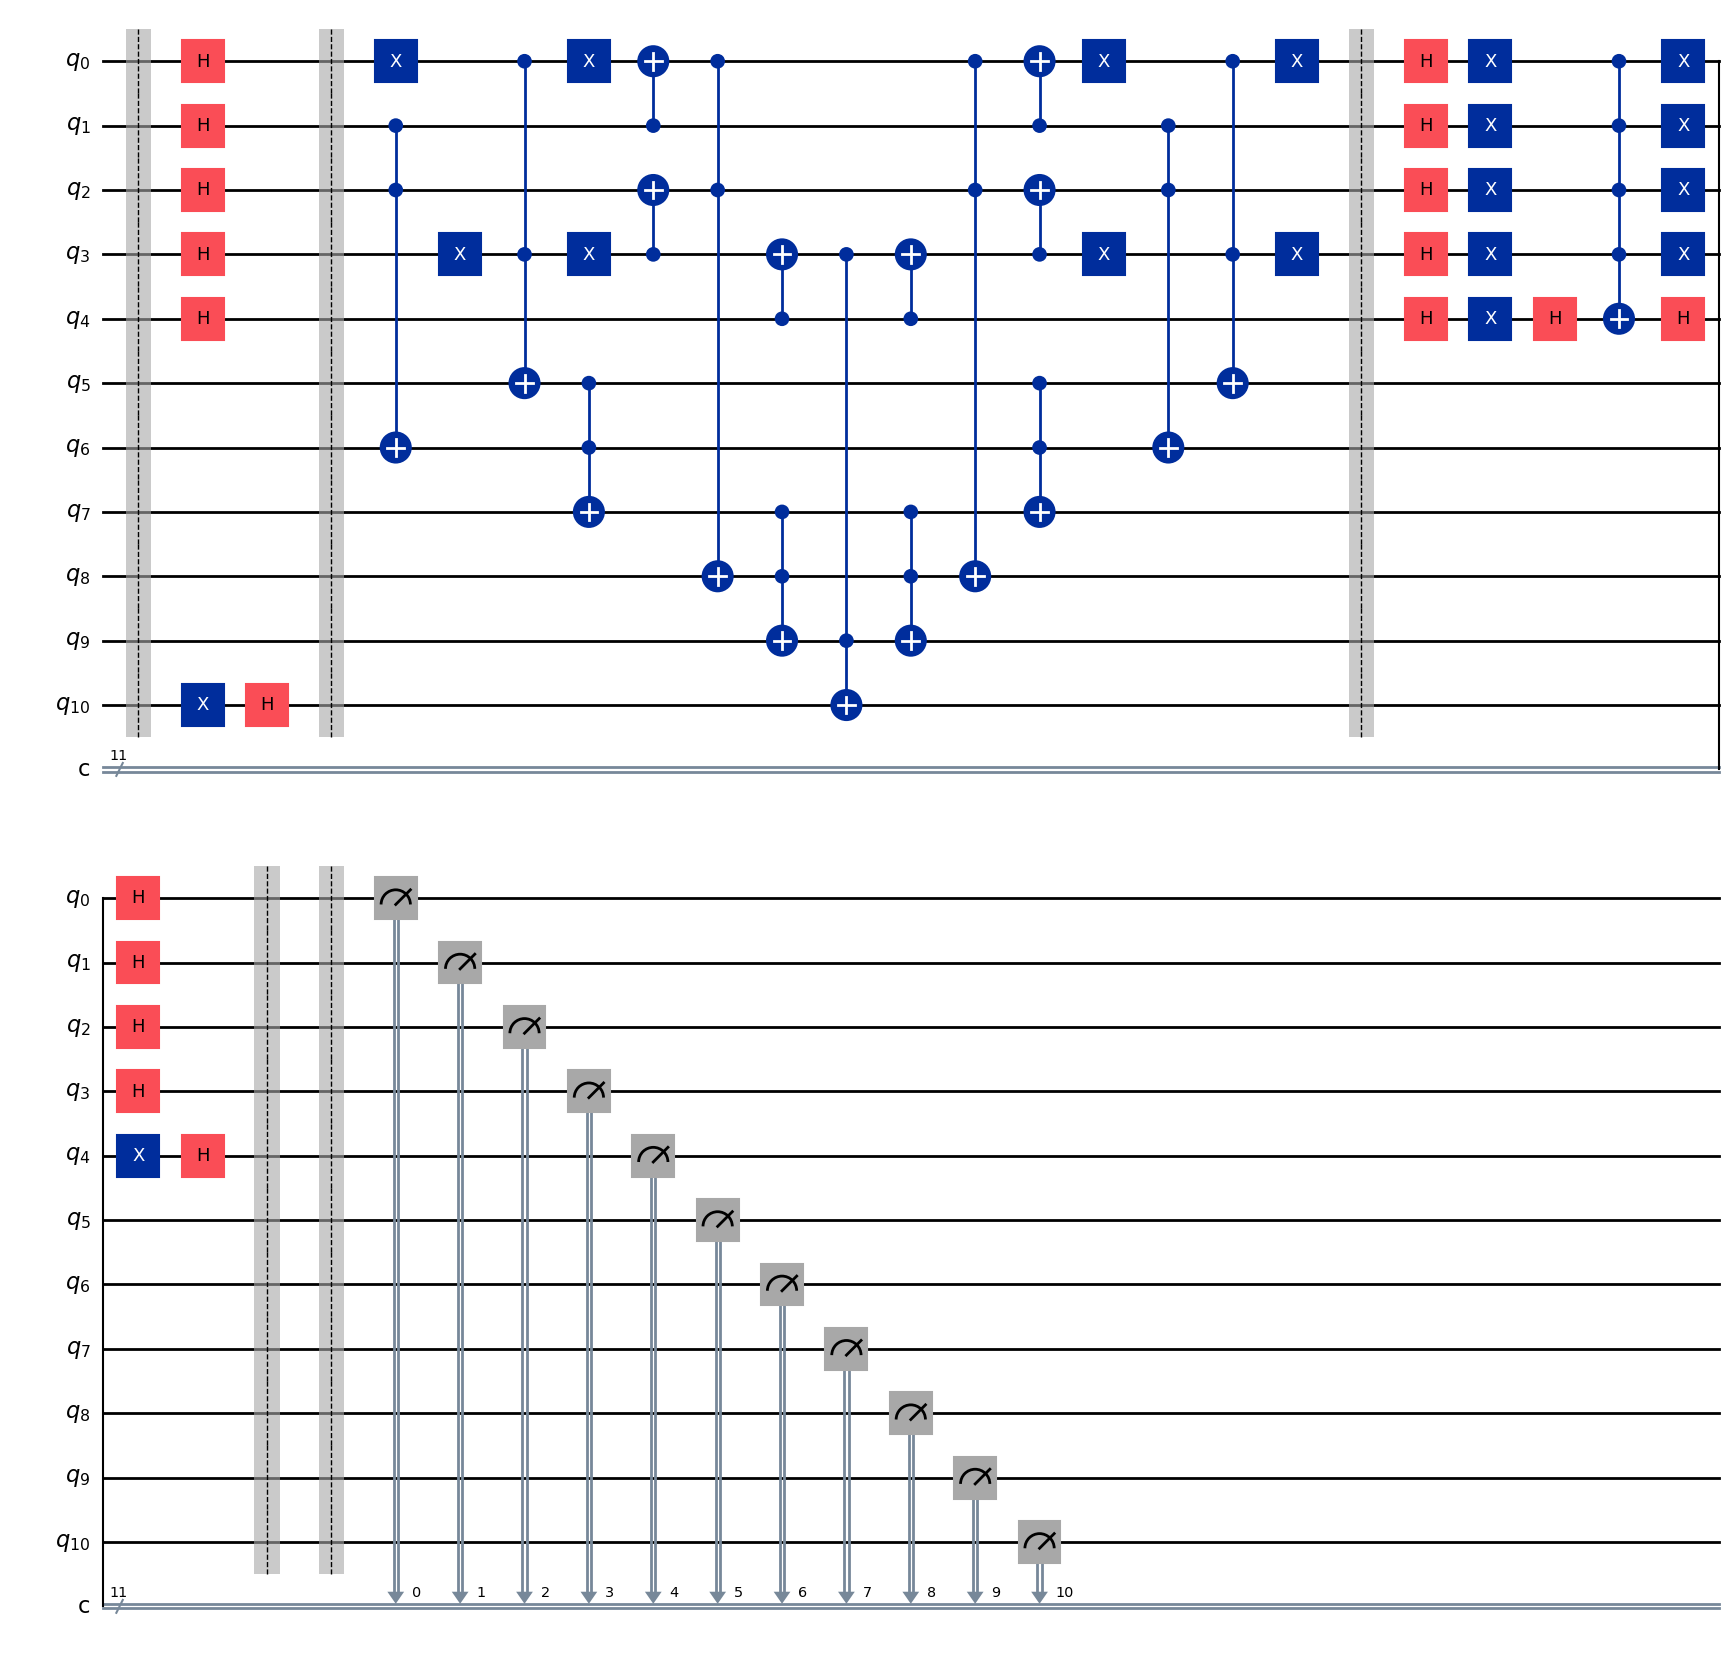

In [29]:
qc_inverted.measure_all(add_bits=False)
# qc_reg.measure(list(range(num_qubits)), list(range(num_qubits))) # Measure the first 3 qubits
qc_decomposed_inverted : QuantumCircuit = qc_inverted.decompose(gates_to_decompose=["state_prep", "grover_oracle_inverted", "grover_diffusion"])
qc_decomposed_inverted.draw('mpl')

### 6. Run the circuits in the AER Simulator

##### Prepare the AER Simulator

In [30]:
from qiskit_aer import Aer
# import basic plot tools
from qiskit.visualization import plot_histogram, plot_distribution

# Creating the backend
qasm_sim = Aer.get_backend('qasm_simulator')

# A function to extract the counts of the useful qubits
def process_counts(counts, num_qubits=3):
    # New dictionary to store our results in.
    new_counts = {f'{i:0{num_qubits}b}': 0 for i in range(2**num_qubits)}

    # Loop through the counts dictionary, adding the value to the 
    # respective key in new_counts based on what state the show_qubit is in
    for count in counts:
        count_idx = (len(count) - num_qubits)
        new_counts[count[count_idx:count_idx+num_qubits]] += counts[count]
    
    return new_counts

#### Regular Circuit

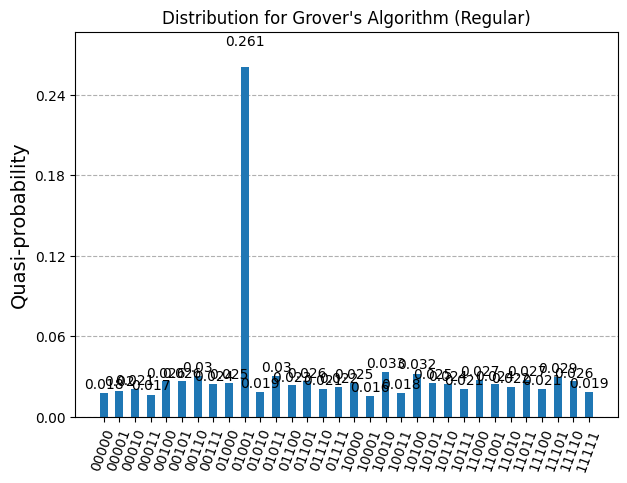

In [32]:
result_reg = qasm_sim.run(qc_decomposed_reg).result()
counts_reg = result_reg.get_counts()
counts_reg = process_counts(counts_reg, num_qubits=num_qubits)

plot_distribution(counts_reg, title="Distribution for Grover's Algorithm (Regular)")

#### Inverted Circuit

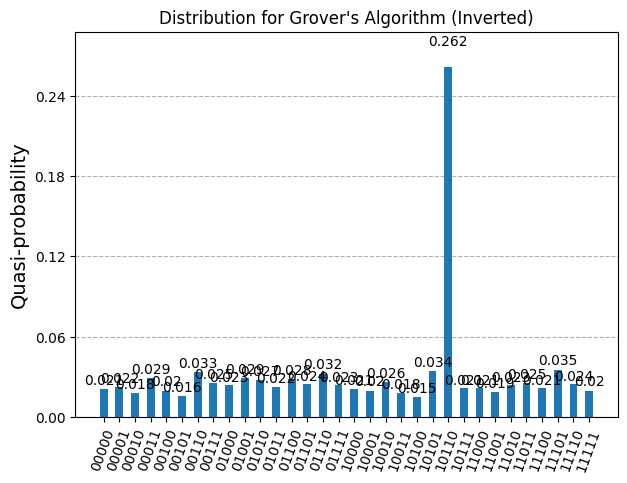

In [33]:
result_inverted = qasm_sim.run(qc_decomposed_inverted).result()
counts_inverted = result_inverted.get_counts()
counts_inverted = process_counts(counts_inverted, num_qubits=num_qubits)

plot_distribution(counts_inverted , title="Distribution for Grover's Algorithm (Inverted)")

### 7. Preparing Real IBM Quantum Device Backends

#### Getting a chosen backend and the least busy backend

In [36]:
# Save account (Only once)

# token = ""
# from qiskit_ibm_runtime import QiskitRuntimeService
 
# QiskitRuntimeService.save_account(
#   token=token,
#   channel="ibm_quantum" # `channel` distinguishes between different account types
# )

In [34]:

# Run our circuit on the least busy backend. Transpiling before running.
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

least_busy_backend = service.least_busy(simulator=False, operational=True)
pick_backend = service.backend("ibm_brisbane")

least_busy_target = least_busy_backend.target
pick_target = pick_backend.target
print(f"Least busy backend: {least_busy_backend.name}")
print(f"The other backend: {pick_backend.name}")

Least busy backend: ibm_sherbrooke
The other backend: ibm_brisbane


#### Dynamic Decoupling Circuit (JB's code)
This code snippet demonstrates the use of dynamic decoupling to mitigate decoherence in quantum circuits. The `PassManager` is configured with the `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` passes to apply dynamic decoupling sequences to the circuit. The optimized circuits are then transpiled and their depths are printed.

In [38]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations

durations = DynamicCircuitInstructionDurations.from_backend(backend=least_busy_backend)
 
optimized_pm = generate_preset_pass_manager(target=least_busy_target, optimization_level=3)
dd_rep = 8
dd_sequence = [XGate()] * dd_rep

optimized_pm.scheduling = PassManager([
    ALAPScheduleAnalysis(durations=durations),
    PadDynamicalDecoupling(
        durations=durations,
        dd_sequences=dd_sequence,
        pulse_alignment=16
    )
])

NUM_TRIAL = 5
reg_transpiled_circuits = []
inverted_transpiled_circuits = []
for i in range(NUM_TRIAL):
    reg_transpiled_circuits.append(optimized_pm.run(qc_reg))
    inverted_transpiled_circuits.append(optimized_pm.run(qc_inverted))


reg_depths = [circuit.depth() for circuit in reg_transpiled_circuits]
inverted_depths = [circuit.depth() for circuit in inverted_transpiled_circuits]
print("Regular Circuit Depths:")
print(reg_depths)
print("Inverted Circuit Depths:")
print(inverted_depths)

Regular Circuit Depths:
[809, 746, 799, 830, 805]
Inverted Circuit Depths:
[816, 762, 730, 871, 898]


In [44]:

print("Regular Circuits Qubits:")
for circuit in reg_transpiled_circuits:
    print(circuit.layout.final_index_layout())
print("Inverted Circuits Qubits:")
for circuit in inverted_transpiled_circuits:
    print(circuit.layout.final_index_layout())


Regular Circuits Qubits:
[55, 49, 70, 67, 66, 68, 69, 74, 50, 89, 65]
[69, 67, 49, 70, 74, 68, 55, 48, 66, 47, 89]
[48, 35, 45, 49, 50, 47, 46, 44, 28, 54, 55]
[49, 55, 70, 67, 66, 68, 69, 89, 50, 74, 65]
[55, 70, 67, 49, 50, 69, 68, 74, 66, 89, 48]
Inverted Circuits Qubits:
[69, 67, 49, 70, 74, 68, 55, 47, 89, 48, 88]
[69, 67, 49, 70, 74, 68, 55, 50, 66, 48, 89]
[55, 67, 70, 49, 50, 68, 69, 74, 66, 89, 48]
[66, 67, 70, 55, 49, 68, 69, 74, 73, 50, 51]
[68, 55, 47, 50, 51, 49, 48, 67, 69, 70, 36]


In [47]:
reg_transpiled_circuit = reg_transpiled_circuits[0]
inverted_transpiled_circuit = inverted_transpiled_circuits[0]
used_qubits_reg = reg_transpiled_circuit.layout.final_index_layout()
used_qubits_inverted = inverted_transpiled_circuit.layout.final_index_layout()

print("Used Qubit for the Regular Circuit:")
print(used_qubits_reg)
print("Used Qubit for the Inverted Circuit:")
print(used_qubits_inverted)

Used Qubit for the Regular Circuit:
[55, 49, 70, 67, 66, 68, 69, 74, 50, 89, 65]
Used Qubit for the Inverted Circuit:
[69, 67, 49, 70, 74, 68, 55, 47, 89, 48, 88]


### 8. Run the circuits in the picked backend

In [48]:
import mthree
mit = mthree.M3Mitigation(least_busy_backend)
# Running the transpiled circuits using the sampler
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=least_busy_backend)
sampler.options.default_shots = 10_000

#### Regular Circuit

In [50]:
mit.cals_from_system(used_qubits_reg)
job_reg = sampler.run([reg_transpiled_circuit])

#### Inverted Circuit

In [57]:
import mthree
mit = mthree.M3Mitigation(least_busy_backend)
mit.cals_from_system(used_qubits_inverted)
job_inverted = sampler.run([inverted_transpiled_circuit])

In [58]:
job_inverted = sampler.run([inverted_transpiled_circuit])

### $\color{yellow}{\text{9. Plot the results }}$

#### Regular Circuit

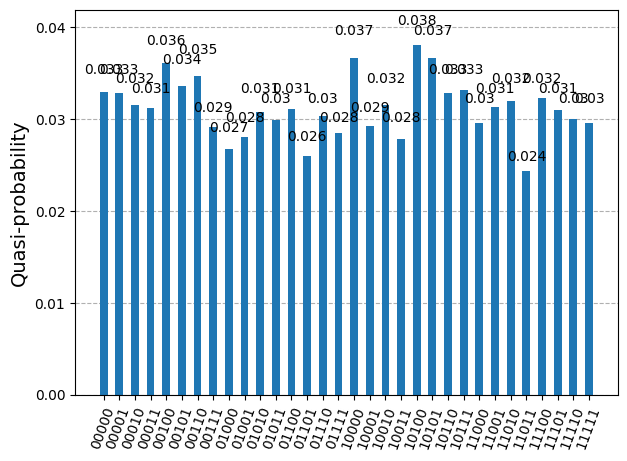

In [54]:
from qiskit.visualization import plot_distribution
result = job_reg.result()
reg_raw_counts = result[0].data.c.get_counts()
counts = process_counts(reg_raw_counts, num_qubits=num_qubits)
plot_distribution(counts)

#### Inverted Circuit

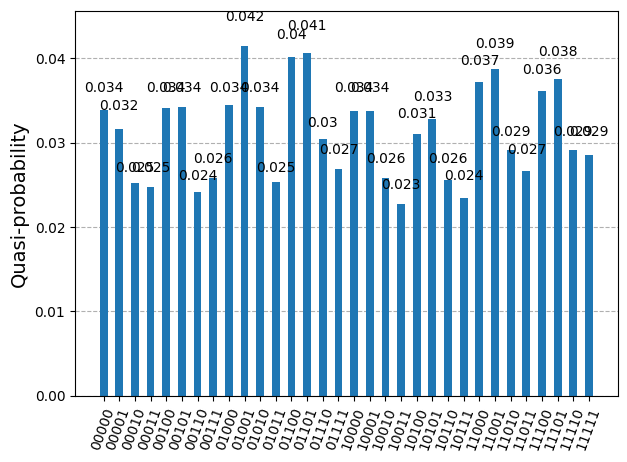

In [59]:
result = job_inverted.result()
inverted_raw_counts = result[0].data.c.get_counts()
counts = process_counts(inverted_raw_counts, num_qubits=num_qubits)
plot_distribution(counts)

### $\color{orange}{\text{10. M3 Mitigation Correction}}$

#### Regular Circuit

In [ ]:
reg_quasi = mit.apply_correction(reg_raw_counts, used_qubits_reg)

mitigated_counts = {k: int(v*10_000) for k, v in reg_quasi.items()}

plot_distribution(process_counts(mitigated_counts))

#### Inverted Circuit

In [ ]:
inverted_quasi = mit.apply_correction(inverted_raw_counts, used_qubits_inverted)

mitigated_counts = {k: int(v*10_000) for k, v in inverted_quasi.items()}

plot_distribution(process_counts(mitigated_counts))

NameError: name 'inverted_raw_counts' is not defined